Idea is is to break down the tasks so that the conversational agent can deal with the different teaching parts effectively. See illustration below:

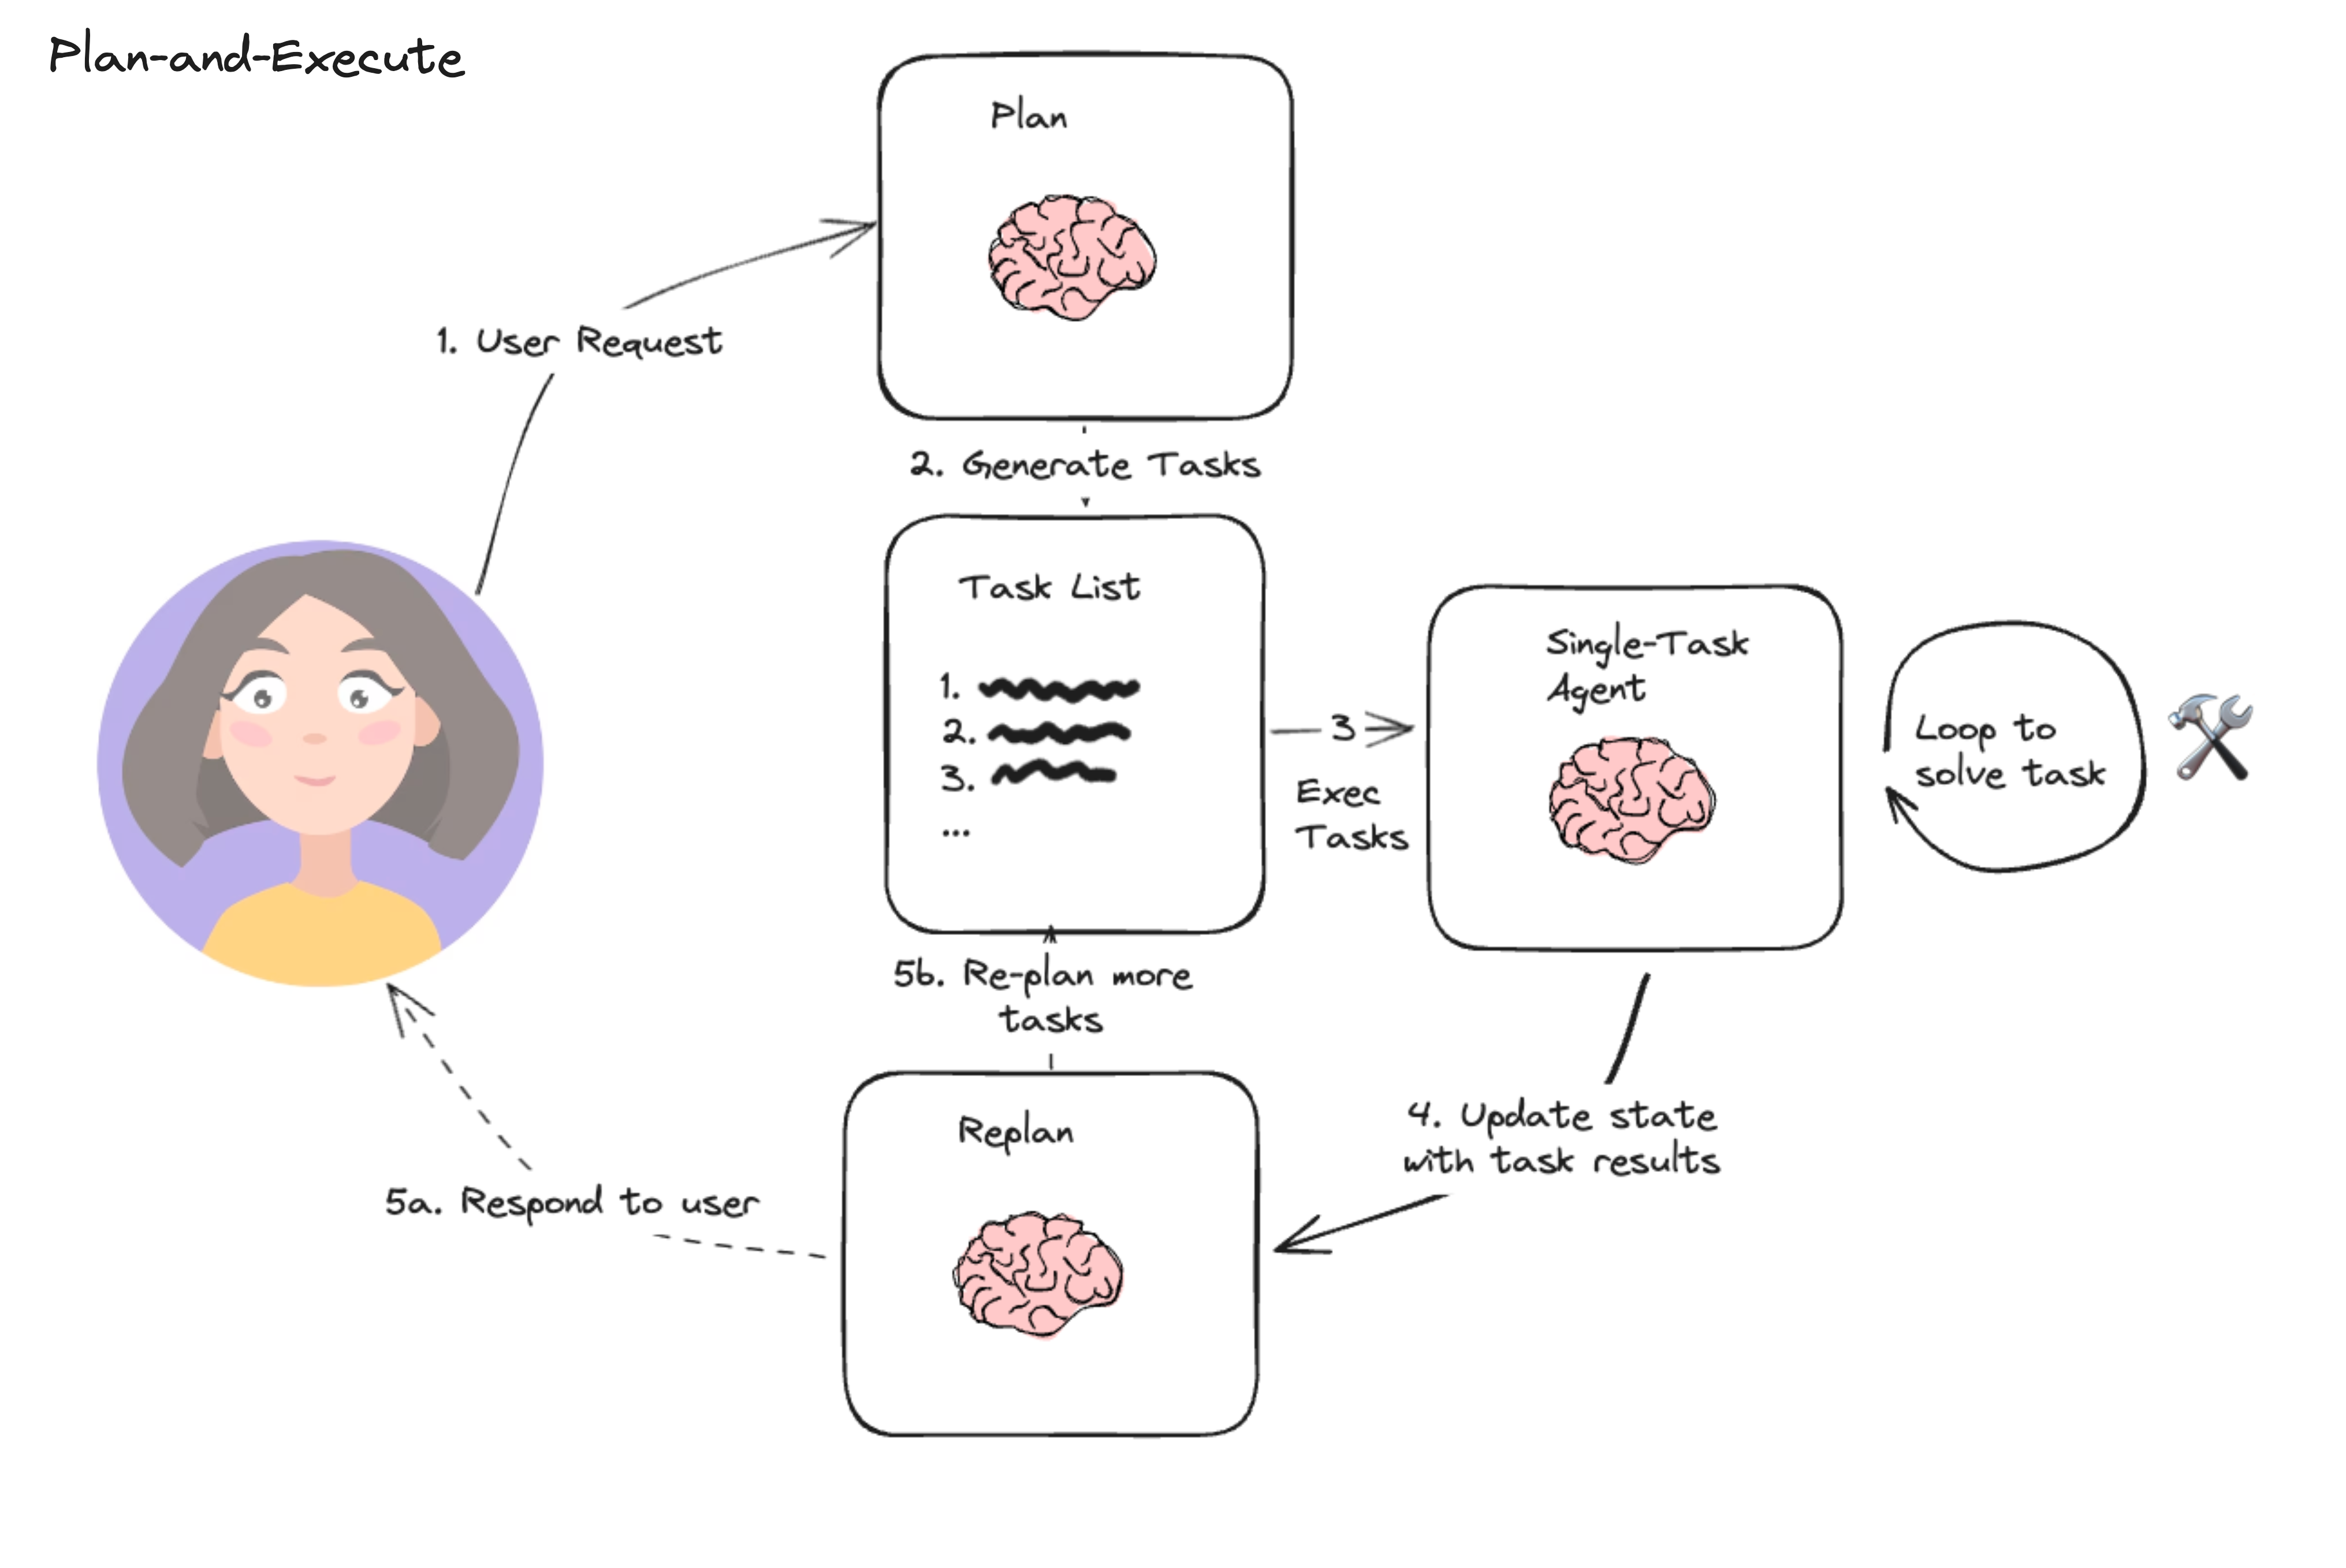

In [29]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

In [30]:
import getpass
import os
from langchain_openai import ChatOpenAI


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

os.environ['OPENAI_API_KEY'] = 'sk-proj-G83o8KfgDs6AYLdJJEavT3BlbkFJsZNRXkuczYp2mVTUY6t4'

os.environ["LANGSMITH_API_KEY"] = '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'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

#for internet request
os.environ['TAVILY_API_KEY'] = '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'

In [31]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [32]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
#*just testing stuff here

def create_conversational_agent(llm, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ( #! too many directives might be complicated for the agent bc it keeps performing randomly
                "system",
                "you are a conversational agent. "
                "you are talking to a student"
                "1. create a conversation scenario using the student's requested subject"
                "2. provide a summary of what was learned after the conversation"
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    return prompt | llm

Now we will create the execution agent we want to use to execute tasks. Note that for this example, we will be using the same execution agent for each task, but this doesn't HAVE to be the case.

In [33]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
# prompt = hub.pull("wfh/react-agent-executor")
# prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo")
agent_executor = create_conversational_agent(llm, system_message="You are a teacher for the English language.") #test with no tools

In [34]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [35]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [36]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-3.5-turbo", temperature=0
).with_structured_output(Plan)

In [37]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-3.5-turbo", temperature=0
).with_structured_output(Act)

In [38]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    print(agent_response)
    return {
        "past_steps": [(task, agent_response.content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [39]:
from langgraph.graph import StateGraph

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

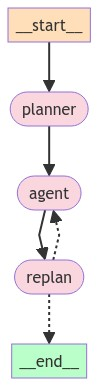

In [40]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [41]:
config = {"recursion_limit": 50}
inputs = {"input": "I am a french A1 student. Can you teach me greetings please?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Learn basic greetings in French']}
content='Student1: Hi, I\'m excited to learn some basic greetings in French today!\n\nTeacher: Bonjour, Student1! I\'m glad you\'re eager to learn. Let\'s start with some simple greetings. In French, "hello" is "bonjour." Can you repeat after me?\n\nStudent1: Bonjour.\n\nTeacher: Très bien! Another common greeting is "good evening," which is "bonsoir." Can you try that?\n\nStudent1: Bonsoir.\n\nTeacher: Parfait! And to say "goodbye," you can say "au revoir."\n\nStudent1: Au revoir.\n\nTeacher: Excellent! You\'re picking it up quickly. Remember to practice these greetings regularly to improve your French skills.\n\nSummary: During the conversation, Student1 learned basic French greetings such as "bonjour" (hello), "bonsoir" (good evening), and "au revoir" (goodbye). The student was able to pronounce and repeat the greetings correctly, showing a good understanding of the lesson. Practice and repetition were emphasized for continued improvemen